<a href="https://colab.research.google.com/github/KingChad127/fri_final_project/blob/master/fri_final_project_training_and_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  9 19:24:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!git clone https://github.com/KingChad127/fri_final_project.git

Cloning into 'fri_final_project'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 390 (delta 82), reused 123 (delta 39), pack-reused 220
Receiving objects: 100% (390/390), 106.67 MiB | 29.46 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [ ]:
!pip3 install -r fri_final_project/requirements.txt

     |████████████████████████████████| 14.6 MB 9.8 MB/s 
     |████████████████████████████████| 26.5 MB 1.2 MB/s 
     |████████████████████████████████| 411.5 MB 7.7 kB/s 
     |████████████████████████████████| 302 kB 92.5 MB/s 
     |████████████████████████████████| 2.9 MB 80.5 MB/s 
     |████████████████████████████████| 3.8 MB 89.4 MB/s 
     |████████████████████████████████| 503 kB 93.6 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 154 kB 75.5 MB/s 
     |████████████████████████████████| 296 kB 76.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=0729e99368eeb59dc6dd97a920537a32f6045aeab387c310a20eb388eba30308
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1

In [ ]:
!pwd

/content


In [ ]:
import os
import sys

ROOT_DIR = "fri_final_project"
sys.path.append(ROOT_DIR)

from mrcnn import utils
from mrcnn.config import Config
from mrcnn import visualize
import mrcnn.model as modellib

import random
from mrcnn.model import log


import matplotlib
import matplotlib.pyplot as plt

import json
import skimage.draw
import numpy as np


Using TensorFlow backend.


In [ ]:
# Directory to save logs and trained model
MODEL_DIR = "drive/MyDrive/Colab Notebooks/"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class ElevatorPanelConfig(Config):
    NAME = "elevator_panel"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2

    STEPS_PER_EPOCH = 100

    DETECTION_MIN_CONFIDENCE = 0.9

    LEARNING_RATE = 0.0007

In [ ]:
config = ElevatorPanelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0007
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
class ElevatorPanelDataset(utils.Dataset):

    def load_elevator(self, dataset_dir, subset):
        # add classes
        self.add_class("elevator_panel", 1, "label")
        self.add_class("elevator_panel", 2, "button")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "masks.json")))
        annotations = list(annotations.values())

        # skip images that have an empty region key
        # aka images with no annotations
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes']
                            for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            ids = []
            for region in a["regions"]:
                ra = region["region_attributes"]
                if ra["Elevator Item"] == "Button":
                    class_id = 2
                else:
                    class_id = 1
                ids.append(class_id)

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "elevator_panel",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                ids=ids)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        # print(image_info)
        polygons = image_info["polygons"]
        count = len(polygons)
        if image_info["source"] != "elevator_panel":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        mask = np.zeros([image_info["height"], image_info["width"], count],
                        dtype=np.uint8)

        for i, p in enumerate(polygons):
            # Get indexes of pixels inside the polygon and set them to 1
            # print(p)
            if p["name"] == "circle":
                rr, cc = skimage.draw.circle(r=p['cy'], c=p['cx'], radius=p['r'])
            elif p["name"] == "rect":
                start = (p['y'], p['x'])
                extent = (p['height'], p['width'])
                rr, cc = skimage.draw.rectangle(start=start, extent=extent)
            elif p["name"] == "ellipse":
                rr, cc = skimage.draw.ellipse(r=p['cy'], c=p['cx'], r_radius=p['ry'], c_radius=p[
                    'rx'], rotation=np.deg2rad(p['theta']))
            else:
                rr, cc = skimage.draw.polygon(
                    r=p['all_points_y'], c=p['all_points_x'])

            mask[rr, cc, i] = 1

        class_ids = np.array(image_info["ids"], dtype=np.uint8)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "elevator_panel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
DATASET_DIR = os.path.join(ROOT_DIR, "elevator_panels")

# Training dataset
dataset_train = ElevatorPanelDataset()
dataset_train.load_elevator(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ElevatorPanelDataset()
dataset_val.load_elevator(DATASET_DIR, "val")
dataset_val.prepare()

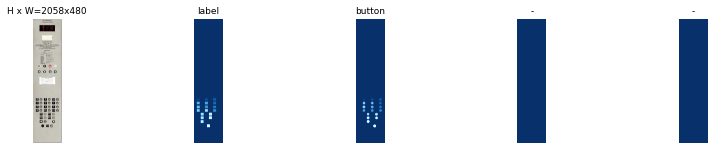

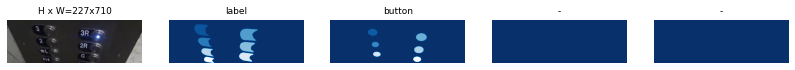

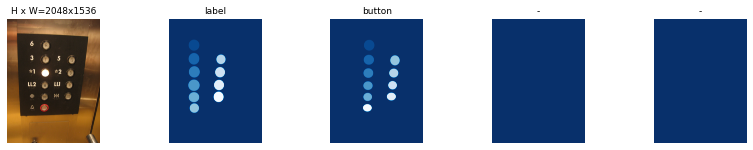

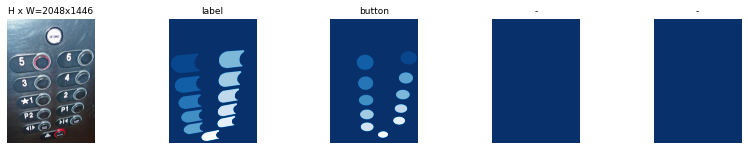

In [ ]:
# Load and display random samples
# image_ids = dataset_train.image_ids
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
# Load dataset
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 83
Class Count: 3
  0. BG                                                
  1. label                                             
  2. button                                            


In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=50,
            layers='heads')

In [ ]:
DRIVE = "/content/drive/MyDrive/Colab Notebooks/mask_rcnn_elevator_panel.h5"
# model.keras_model.save_weights(DRIVE)

In [ ]:
class InferenceConfig(ElevatorPanelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = DRIVE
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/Colab Notebooks/mask_rcnn_elevator_panel.h5








original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4032.00000  float64
gt_class_id              shape: (16,)                 min:    1.00000  max:    2.00000  uint8
gt_bbox                  shape: (16, 4)               min:  125.00000  max:  906.00000  int32
gt_mask                  shape: (1024, 1024, 16)      min:    0.00000  max:    1.00000  bool


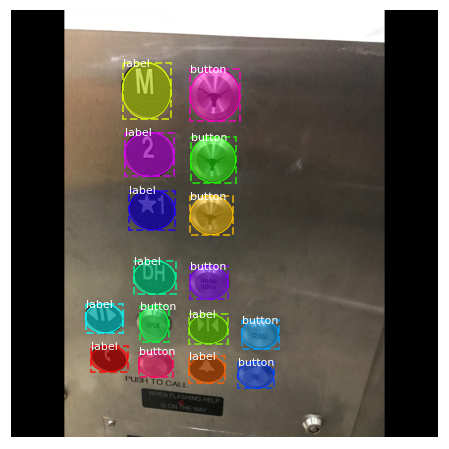

In [ ]:
image_id = random.choice(dataset_val.image_ids)
# image_id = dataset_val.image_ids[1]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


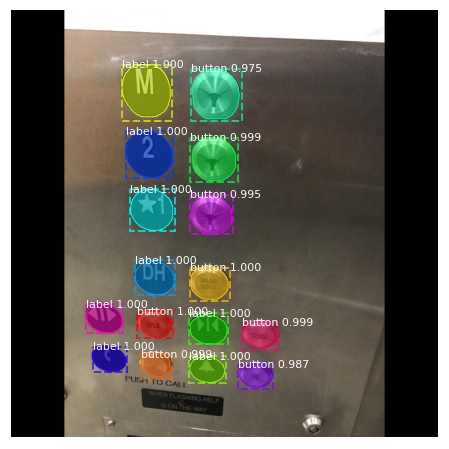

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9545454545454546
